In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')

## Create synthetic signal
dt = 0.001
t = np.arange(0, 1, dt)
signal = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t) #composite signal
signal_clean = signal #copy for later comparison
signal = signal + 2.5 * np.random.randn(len(t))
minsignal, maxsignal = signal.min(), signal.max()

In [2]:
## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(signal, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index

In [3]:
## Filter out noise
threshold = 100
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

e:\Source\cryingbaby\teste-filtro-audio\venv-bcd\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


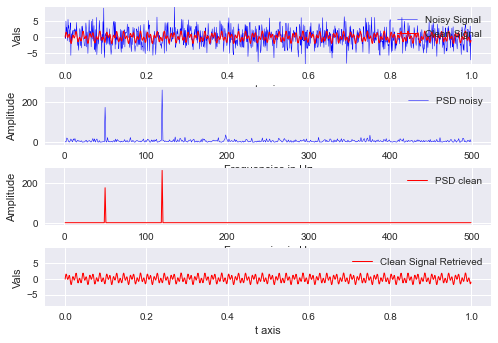

In [4]:
## Visualization
fig, ax = plt.subplots(4,1)
ax[0].plot(t, signal, color='b', lw=0.5, label='Noisy Signal')
ax[0].plot(t, signal_clean, color='r', lw=1, label='Clean Signal')
ax[0].set_ylim([minsignal, maxsignal])
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Vals')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd[idxs_half]), color='b', lw=0.5, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='r', lw=1, label='PSD clean')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, signal_filtered, color='r', lw=1, label='Clean Signal Retrieved')
ax[3].set_ylim([minsignal, maxsignal])
ax[3].set_xlabel('t axis')
ax[3].set_ylabel('Vals')
ax[3].legend()

plt.subplots_adjust(hspace=0.4)
plt.savefig('signal-analysis.png', bbox_inches='tight', dpi=300)

Real data denoising using power threshold

In [ ]:
# -*- coding: utf-8 -*-
# ======================================================================================================================================================
"""
Created on Thu Apr 29 12:41:26 2021

@author: Utpal Kumar (IES, Academia Sinica)
"""
# ======================================================================================================================================================

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')
from obspy import read
from obspy.core import UTCDateTime


otime = UTCDateTime('2021-04-18T22:14:37') #eq origin

filenameZ = 'TW-RCEC7A-BNZ.mseed'

stZ = read(filenameZ)
streams = [stZ.copy()]
traces = []
for st in streams:
    tr = st[0].trim(otime, otime+120)
    traces.append(tr)
    
delta = stZ[0].stats.delta
starttime = np.datetime64(stZ[0].stats.starttime)
endtime = np.datetime64(stZ[0].stats.endtime)
signalZ = traces[0].data/10**6
minsignal, maxsignal = signalZ.min(), signalZ.max()

t = traces[0].times("utcdatetime") 

## Compute Fourier Transform
n = len(t)
fhat = np.fft.fft(signalZ, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq = (1/(delta*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
psd_real = np.abs(psd[idxs_half]) #amplitude for first half


## Filter out noise
sort_psd = np.sort(psd_real)[::-1]
# print(len(sort_psd))
threshold = sort_psd[300]
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform


## Visualization
fig, ax = plt.subplots(4,1)
ax[0].plot(t, signalZ, color='b', lw=0.5, label='Noisy Signal')
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Accn in Gal')
ax[0].legend()

ax[1].plot(freq[idxs_half], np.abs(psd[idxs_half]), color='b', lw=0.5, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='r', lw=1, label='PSD clean')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, signal_filtered, color='r', lw=1, label='Clean Signal Retrieved')
ax[3].set_ylim([minsignal, maxsignal])
ax[3].set_xlabel('t axis')
ax[3].set_ylabel('Accn in Gal')
ax[3].legend()

plt.subplots_adjust(hspace=0.6)
plt.savefig('real-signal-analysis.png', bbox_inches='tight', dpi=300)

Obspy based filter

In [9]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')
from obspy import read
from obspy.core import UTCDateTime

otime = UTCDateTime('2021-04-18T22:14:37') #eq origin

#filenameZ = 'TW-RCEC7A-BNZ.mseed'
filenameZ = 'E:\\Source\\cryingbaby\\teste-filtro-audio\\baby_cry_detection\\baby_cry_detection\\prediction_simulation\\choro1.ogg'

stZ = read(filenameZ)
streams = [stZ.copy()]
traces = []
for st in streams:
    tr = st[0].trim(otime, otime+120)
    traces.append(tr)
    

signalZ = traces[0].data/10**6
minsignal, maxsignal = signalZ.min(), signalZ.max()

t = np.arange(0, traces[0].stats.npts / traces[0].stats.sampling_rate, traces[0].stats.delta)

# Filtering with a lowpass on a copy of the original Trace
freqmin = 0.01
freqmax = 3
tr_filt = traces[0].copy()
tr_filt.detrend("linear")
tr_filt.taper(max_percentage=0.05, type='hann')
tr_filt.filter("bandpass", freqmin=freqmin,
                          freqmax=freqmax, corners=4, zerophase=True)
print(tr_filt.data/10**6)
signal_filtered = tr_filt.data/10**6

## Visualization
fig, ax = plt.subplots(2,1)
ax[0].plot(t, signalZ, color='b', lw=0.5, label='Noisy Signal')
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Accn in Gal')
ax[0].legend()


ax[1].plot(t, signal_filtered, color='r', lw=1, label='Clean Signal Retrieved')
ax[1].set_xlabel('t axis')
ax[1].set_ylabel('Accn in Gal')
ax[1].set_title(f"Filtered in range {freqmin}-{freqmax} Hz")
ax[1].legend()

plt.subplots_adjust(hspace=0.4)
plt.savefig('real-signal-analysis.png', bbox_inches='tight', dpi=300)

TypeError: Unknown format for file E:\Source\cryingbaby\teste-filtro-audio\baby_cry_detection\baby_cry_detection\prediction_simulation\choro1.ogg